# Machine Learning: Assignment #3
### Topics:
- Multiclass Classification
- PAC, VCdim
- Bias vs Variance
- Cross validation
- Linear Regression
- Decision Trees

By: Dema Omar , Aya Fodi

## Part 1 - Multiclass SVM

*We* will implement and compare different multiclass methods in both separable and non separable cases.

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

Implementation of the One-vs-One Classifier

This code implements a custom One-vs-One (OvO) classifier using linear SVM models.
Each pair of classes is trained separately, and during prediction, all models vote for their predicted class.
The final label for each sample is determined by majority voting across all binary classifiers.

In [ ]:
from collections import defaultdict

class OneVsOneClassifier:
    def __init__(self, n_classes=2, C=1.0):
        # Initialize number of classes and SVM regularization parameter
        self.n_classes = n_classes
        self.C = C

        # Dictionary to store all binary classifiers (one per class pair)
        self.estimators = defaultdict(None)

    def fit(self, X, y):
        # Train one SVM classifier for every unique pair of classes
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                # Select only samples from the two classes (i, j)
                filter = np.logical_or(y == i, y == j)
                temp_X = X[filter]
                temp_y_filter = y[filter]

                # Convert labels: class i -> +1, class j -> -1
                temp_y = np.copy(temp_y_filter)
                temp_y[temp_y_filter == i] = 1
                temp_y[temp_y_filter == j] = -1

                # Create and train a linear SVM for this pair
                self.estimators[(i, j)] = SVC(kernel='linear', C=self.C)
                self.estimators[(i, j)].fit(temp_X, temp_y)

    def predict(self, X):
        # Create a score matrix to count votes for each class
        scores = np.zeros((self.n_classes, len(X)))

        # Each classifier votes for one of its two classes
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                scores[i] += (self.estimators[(i, j)].predict(X) == 1)
                scores[j] += (self.estimators[(i, j)].predict(X) == -1)

        # The class with the most votes is chosen as the prediction
        return np.argmax(scores, axis=0)

    def score(self, X, y):
        # Compute accuracy of predictions
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

The data

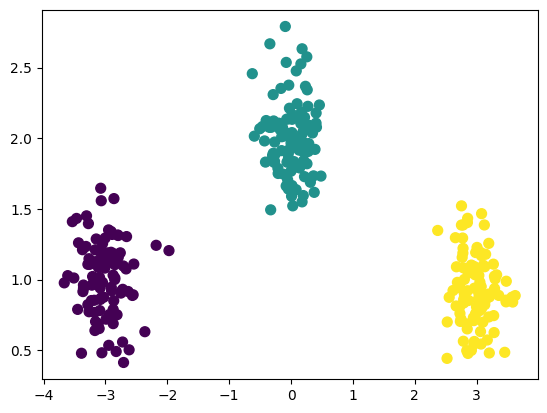

In [ ]:
from sklearn.datasets import make_blobs

np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

Testing the Classifier:

The classifier is evaluated using a confusion matrix and decision boundary plots.
Since the data is linearly separable, the value of C has no real effect — there are no errors to penalize, so the model’s performance remains unchanged.

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

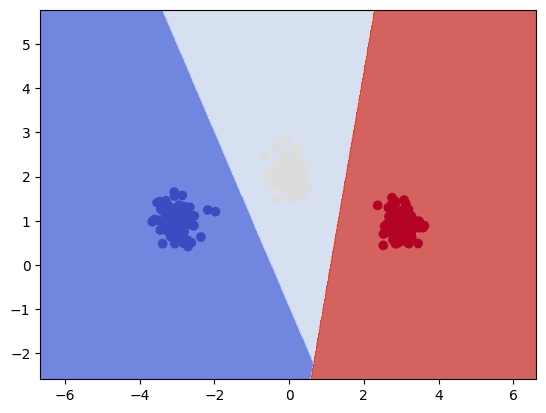

In [ ]:
from sklearn import metrics

clf_onevsall = OneVsOneClassifier(n_classes=3, C=2)
clf_onevsall.fit(X,y)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


metrics.confusion_matrix(y, clf_onevsall.predict(X))

Generate another data



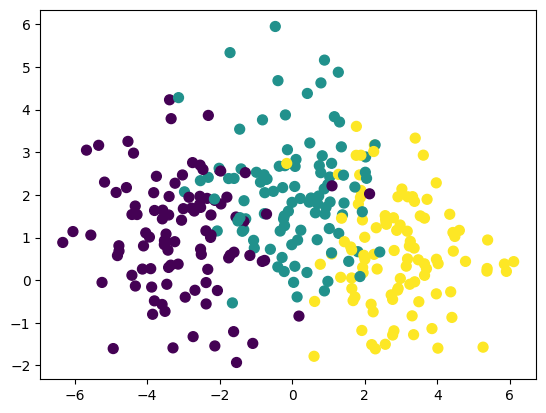

In [ ]:
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=1.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

as C→0 we allow more erros in the train then The accuracy on the training data decreases because the model is more tolerant of errors and focuses on maximizing the margin. but the accuracy on the test data increase. This indicates better generalization because the model is not overfitting to the training data and is able to generalize better to unseen data.
as C→∞ we allows fewer errors. This means the model becomes very strict about correctly classifying all training examples. While this may minimize errors on the training set, it can lead to overfitting, where the model captures noise and specific patterns of the training data that do not generalize to unseen data. Consequently, the test accuracy as we see is lower, bacuse poor generalization to new data.   </font>

100%|██████████| 4/4 [00:00<00:00, 27.97it/s]


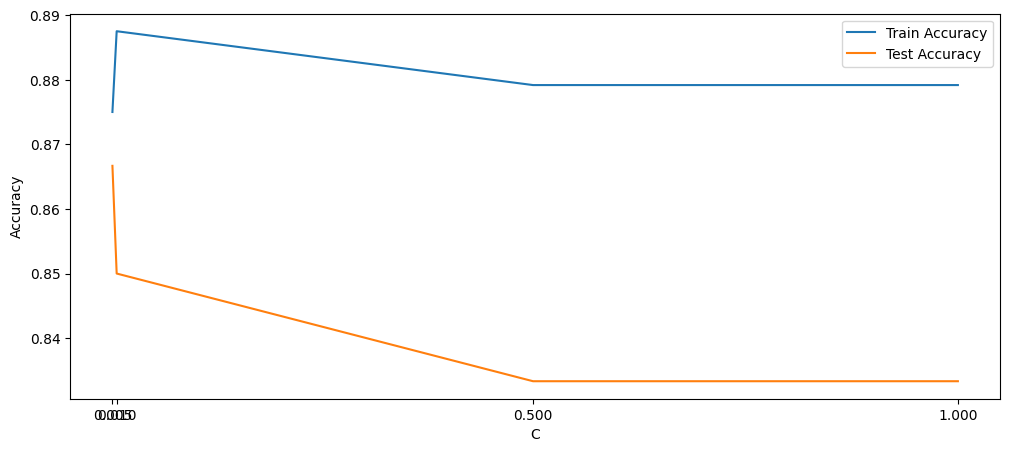

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of C values
C_values = [5e-3, 1e-2, 0.5, 1]

train_accuracies = []
test_accuracies = []

for C in tqdm(C_values):
    # Create a new OneVsOneClassifier instance
    clf_onevsall = OneVsOneClassifier(n_classes=3, C=C)

    # Fit the classifier on the training data
    clf_onevsall.fit(X_train, y_train)

    # Calculate the train and test accuracies
    train_accuracy = clf_onevsall.score(X_train, y_train)
    test_accuracy = clf_onevsall.score(X_test, y_test)

    # Append the accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the train and test accuracies as a function of C

plt.figure(figsize=(12,5))
plt.plot(C_values, train_accuracies, label="Train Accuracy")
plt.plot(C_values, test_accuracies, label="Test Accuracy")
plt.xlabel("C")
plt.xticks(C_values)
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Now, we will experience little bit from softmax. It uses neural networks,. The importand part is the preidction, which is obtained by:
```
def forward(self, x):
        out = self.linear(x)
        return torch.softmax(out, dim=1)
```
Note that this is exactly that you saw - linear score $s_j$ and then applying softmax.

The best results are obtained using 300 epochs (iterations) and in each iteration the batch size is the entire data. <br/>
1. What happens as you use 100,600 epcohs compared to 300? why is that?
2. Use 300 epochs with batch size 50 vs the entire data. How does the batch size affect the convergence of the problem?

1-When we try 300 epochs, we get an accuracy of 0.8167 (the best). This indicates that the model has enough iterations to learn the data and achieve a balance between learning and generalization. With 600 epochs, the accuracy drops to 0.8, which suggests that the model has undergone too many iterations and has started overfitting on the training data, losing its ability to generalize well to new data. When using 100 epochs, the accuracy is 0.7833 (lower than 0.8167), indicating that the model does not have enough iterations to learn the data adequately, leading to underfitting and lower accuracy.


2-
When we use the entire dataset as the batch size, we get an accuracy of 0.8167. In contrast, when the batch size is 50, we get an accuracy of 0.7833. Although using a smaller batch size (like 50) makes each iteration faster because it processes fewer samples at a time, it results in less accurate  updates due to not using the entire dataset. This  lead to lower accuracy. Using the entire dataset for each batch, while slower, provides more accurate updates, leading to better accuracy.   </font>

In [ ]:
num_epochs = 300
batch_size = len(X_train) // 3
print(f"Training size is {len(X_train)} samples and batch size is {batch_size}")

Training size is 240 samples and batch size is 80


In [ ]:
#@title This will train the model using softmax

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear1.weight.data.fill_(1)
        self.linear1.bias.data.fill_(1)

    def forward(self, x):
        out = self.linear1(x)
        return torch.softmax(out, dim=1)

# Set hyperparameters
input_size = X_train_tensor.shape[1]
output_size = len(torch.unique(y_train_tensor))
learning_rate = 0.01

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Instantiate the model and define the optimizer
model = SimpleNN(input_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


# Evaluate the model on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.8000


array([[94,  4,  2],
       [19, 69, 12],
       [ 0,  9, 91]])

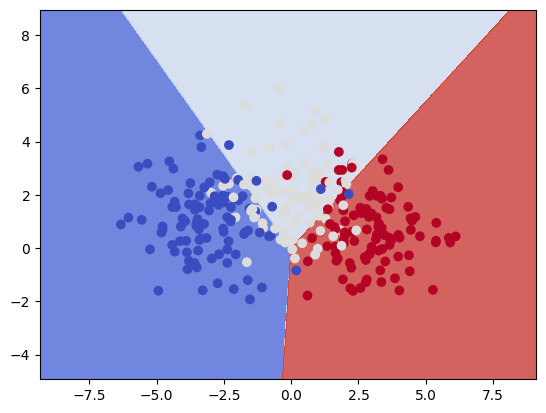

In [ ]:
#@title This will plot the boundaries of the model

def predict(data):
    outputs = model(torch.tensor(data, dtype=torch.float32))
    _, predicted = torch.max(outputs, 1)
    return predicted

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, predict(X))

## Part 2 - Linear Regression
We are requested by the Charles Darvin himself to predict the age of abalone from physical measurements.
The dataset consists of 7 continious features that he has collected for you.

In [ ]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

We define the following:
-	X, 2d matrix from size n x d which represents the training samples.
-	y, array from size n which represents the target value for the corresponding sample.

Implement the function Linreg_sol(X,y) which outputs the closed form solution for linear regression on X,y : <br/>


In [ ]:
def Linreg_sol(X, y):
    S = np.linalg.inv(X.T @ X) @ X.T @ y
    return S

Load data from https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv

In [ ]:
df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv')

Our tasks are:
- Convert to numpy
- Preproccess the data
- Find the weight vector and the bias

In [ ]:
data = df.to_numpy()

X = data[:, :-1]
y = data[:, -1]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
X = scaled_X

n = X.shape[0]
X = np.hstack((np.ones((n, 1)), X))
w = Linreg_sol(X, y)

# Suppose w is the solution
print(f'The linear line is {w[1]:.2f}x1+{w[2]:.2f}x2+{w[3]:.2f}x3+{w[4]:.2f}x4+{w[5]:.2f}x5+{w[6]:.2f}x6+{w[7]:.2f}x7+{w[0]:.2f}=0')

The linear line is -0.18x1+1.32x2+0.50x3+4.53x4+-4.49x5+-1.08x6+1.20x7+9.93=0


Now, implement 'Linreg_sol_via_GD' which implement gradient descent on the linear regression problem. The stopping criterion should be based only by the iterations number recived as parameter

In [ ]:
def Linreg_sol_via_GD(X, y, iter_number, lr):
    w = np.ones(X.shape[1])
    k = X.shape[0]
    X0 = X[:, 1:]
    for i in range(iter_number):
        first_w = w[0]
        last_w = w[1:]
        err = X @ w - y
        grad_first = 1 / k * np.sum(err)
        grad_last = 1 / k * np.sum(err[:, np.newaxis] * X0, axis=0)
        first_w -= lr * grad_first
        last_w -= lr * grad_last

        w = np.append(first_w, last_w)

    return w

The following code measures the number of iterations as a function of the error gap between the returned weights and the correct solution. <br/>
Conclude the complexity formula required - How many iterations do we need as a function of the error, $\varepsilon$? Make sure to include the $𝚶$ notation in your answer. <br/>

<font color='red'> 𝑂(1/𝜖),the number of iterations required for convergence decreases inversely with the required error 𝜖. the smaller the required error, the more linearly the number of iterations required.</font>

100%|██████████| 90/90 [01:35<00:00,  1.07s/it]


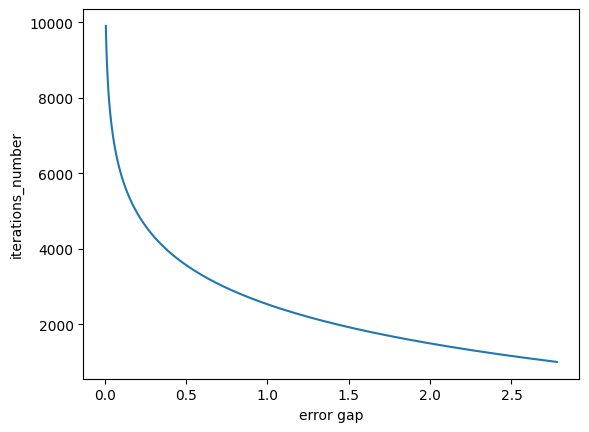

In [ ]:
w_real = w

iters = np.arange(1000, 10_000, 100)
gaps = []

for iter in tqdm(iters):
   w = Linreg_sol_via_GD(X, y,iter,lr=0.1)
   gaps.append(np.linalg.norm(w_real - w))

plt.plot(gaps, iters)
plt.ylabel("iterations_number")
plt.xlabel("error gap")
plt.show()

In the second part of the task, we will see the features dependence and try to solve it.

Calculate the the value of $\text{Cov}(X)=\frac{1}{n-1}(X-\mu)^\top (X-\mu)$? <br/>
- What can you imply from this about the features?
- Can we imply something on $X^\top X$? Must its det be 0?
 <br/>
<font color='red'>
1)Cov(𝑋) helps us understand the relationships between features, because if we look at the diagonal elements of the covariance matrix we can learn the variances of each feature and  from the off diagonal elements we can learn the linear relationships between the features.

2)yes we can,if det(X⊤X)=0
it implies that there are linearly dependent features in 𝑋 .and the det does not have to be zero.</font>

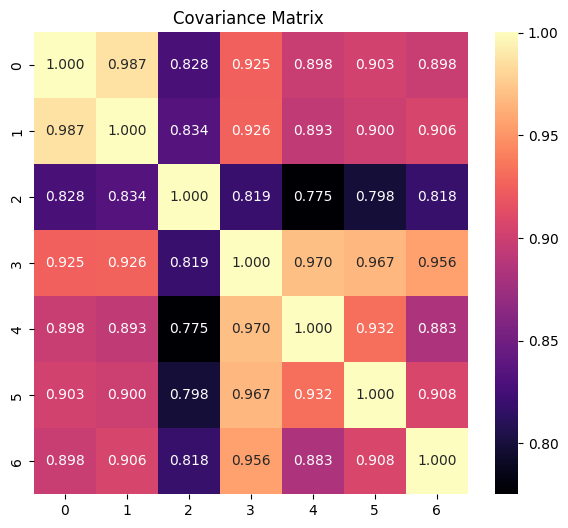

In [ ]:
X1 = X[:, 1:]
X=X1

mu = np.mean(X, axis=0)

X_centered = X - mu

n = X.shape[0]
Cov_X = (1 / (n - 1)) * (X_centered.T @ X_centered)
cov_df = pd.DataFrame(Cov_X)

plt.figure(figsize=(7, 6))
sns.heatmap(cov_df, annot=True, fmt=".3f", cmap="magma", cbar=True)
plt.title('Covariance Matrix ')
plt.show()


Implement the solution to ridge regression using GD.

In [ ]:
def Linreg_sol_Ridge(X, y, lamda):

    I = np.eye(X.shape[1])
    w = np.linalg.inv(X.T @ X + lamda * I) @ X.T @ y
    return w

The following code measures the mse error as function of the regularization hyperparameter lamda. <br/>Explain the origin to the mse' behaviour as function of lamda in this problem. <br/>
<font color='red'>
The plot shows the error increasing as the lambda value gets larger. In ridge regression, lambda sets how much we penalize large coefficients. A small lambda means a small penalty, so the model fits the training data well and has low error. When lambda is large, the penalty is high, making the model too simple and unable to fit the data well, causing the error to rise.</font>

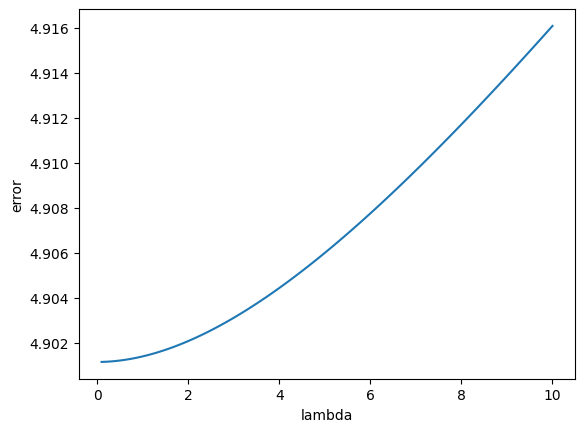

In [ ]:
mses = []
lamdas = np.arange(0.1, 10.1, 0.1)

for lamda in lamdas:
    n = X.shape[0]
    X_for_reg = np.hstack((np.ones((n, 1)), X))
    w = Linreg_sol_Ridge(X_for_reg, y, lamda)

    preds = np.dot(X_for_reg, w)
    mses.append(np.mean((preds - y) ** 2))

plt.plot(lamdas, mses)
plt.ylabel("error")
plt.xlabel("lambda")

plt.show()

## Part 3 - Decision tree

Wine Classification Using Decision Trees:

In this part, the wine dataset from HW1 is revisited.
The goal is to classify different wine types based on their physical and chemical properties, this time using a Decision Tree model to explore interpretability and feature importance.

In [ ]:
# Import libraries

import numpy as np
import pandas as pd

In [ ]:
# Load the data, print the first rows

data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw1/wine.data.csv')
data.head(3)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1


Complete this missing implementation of the following functions:
- ```calculate_entropy(self, data)``` – given data, compute the entropy, where the distribution is over its labels (target class).
- ```calculate_information_gain(self, data, feature)``` – given data and specific feature, compute the information gain given by selecting that feature.



In [ ]:
# Define the ID3 decision tree class
class DecisionTree:
	def __init__(self, max_depth=np.inf):
		self.tree = {}
		self.max_depth = max_depth

	def calc_p(self, fea, data):
		if(len(data)!=0):
			return len(fea) / len(data)


	def calculate_entropy(self, data):
		labels = data.iloc[:, -1]


		unique_lab = np.unique(labels)
		entropy = 0
		for i in unique_lab:
			curr_fea = data[labels == i]
			p_i = self.calc_p(curr_fea, labels)
			entropy += -p_i * np.log2(p_i)

		return entropy


	def calculate_information_gain(self, data, feature):
		total_entropy = self.calculate_entropy(data)
		information_gain = total_entropy

		best_treshold = None
		best_gain = 0
		values = np.linspace(data[feature].min(), data[feature].max(), 10)
		for value in values:
			left = self.filter_data(data, feature, value, left=True)
			right = self.filter_data(data, feature, value, left=False)

			p_left = self.calc_p(left, data)
			p_right = self.calc_p(right, data)

			entropy_left = self.calculate_entropy(left)
			entropy_right = self.calculate_entropy(right)

			gain = total_entropy - (p_left * entropy_left + p_right * entropy_right)
			if gain > best_gain:
				best_gain = gain
				best_treshold = value

		return best_gain, best_treshold

	def filter_data(self, data, feature, value, left=True):
		if left:
			return data[data[feature] <= value].drop(feature, axis=1)
		else:
			return data[data[feature] > value].drop(feature, axis=1)

	def create_tree(self, data, depth=0):
		# Recursive function to create the decision tree
		labels = data.iloc[:, -1]

		# Base case: if all labels are the same, return the label
		if len(np.unique(labels)) == 1 :
			return list(labels)[0]


		features = data.columns.tolist()[:-1]
		# Base case: if there are no features left to split on, return the majority label
		if len(features) == 0 or depth >= self.max_depth :
			unique_labels, label_counts = np.unique(labels, return_counts=True)
			majority_label = unique_labels[label_counts.argmax()]
			return majority_label

		selected_feature = None
		best_gain = 0
		best_treshold = None

		for feature in features:
			gain, treshold = self.calculate_information_gain(data, feature)
			if gain >= best_gain:
				selected_feature = feature
				best_treshold = treshold
				best_gain = gain

		# Create the tree node
		tree_node = {}
		tree_node[(selected_feature, f"<={best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=True), depth+1)
		tree_node[(selected_feature, f">{best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=False), depth+1)

		# check if can unite them.
		if not isinstance(tree_node[(selected_feature, f"<={best_treshold}")], dict) and \
				not isinstance(tree_node[(selected_feature, f">{best_treshold}")], dict):
			if tree_node[(selected_feature, f"<={best_treshold}")] == tree_node[(selected_feature, f">{best_treshold}")]:
				return tree_node[(selected_feature, f"<={best_treshold}")]

		return tree_node

	def fit(self, data):
		self.tree = self.create_tree(data)

	def predict(self, X):
		X = [row[1] for row in X.iterrows()]

		# Predict the labels for new data points
		predictions = []

		for row in X:
			current_node = self.tree
			while isinstance(current_node, dict) :
				split_condition = next(iter(current_node))
				feature, value = split_condition
				treshold = float(value[2:])
				if row[feature] <= treshold:
					current_node = current_node[feature, f"<={treshold}"]
				else:
					current_node = current_node[feature, f">{treshold}"]
			predictions.append(current_node)

		return predictions

	def _plot(self, tree, indent):
		depth = 1
		for key, value in tree.items():
			if isinstance(value, dict):
				print(" " * indent + str(key) + ":")
				depth = max(depth, 1 + self._plot(value, indent + 2))
			else:
				print(" " * indent + str(key) + ": " + str(value))
		return depth

	def plot(self):
		depth = self._plot(self.tree, 0)
		print(f'depth is {depth}')


We are ready - define DecisionTree, fit it on the entire data and plot the tree. <br/>
The depth of the tree should be 5:

In [ ]:
decision_tree = DecisionTree()
decision_tree.fit(data)
decision_tree.plot()

The decision tree is pretty large (depth is 5). To solve this, lets modify our DecisionTree: <br/>
```
def __init__(self, max_depth=np.inf):
        self.tree = {}
        self.max_depth = max_depth
```

Modify the rest of the code to stop growing after max_depth. <br/>
Hint: When reached to max_depth, should we continue splitting? Which category will be best to be selected?


Using 10 thresholds, compare using max_depth=2 and max_depth=4. Based on the results, which depth is better for our problem in term of ML? <br/>

As we see when the maximum depth is 2, the training accuracy was 92.25% and the test accuracy was 88.89%. When the depth increased to 4, the training accuracy improved to 98.59%, but the test accuracy remained the same at 88.89%. This means that while a deeper model fits the training data better, it doesn't improve on new test data, leading to overfitting. Therefore, a depth of 2 is better because it keeps the model simpler and avoids overfitting while maintaining similar test accuracy.</font>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
train, test = train_test_split(data, test_size=0.2, random_state=42)

train_label = train.iloc[:, -1]
test_label = test.iloc[:, -1]
for depth in [2, 4]:
  print(f"------------ max_depth={depth} ------------")
  decision_tree1 = DecisionTree(max_depth=depth)
  decision_tree1.fit(train)

  train_pre_label = decision_tree1.predict(train)
  acc =  accuracy_score(train_label,train_pre_label)
  print(f'Training accuracy is {acc}')

  test_pre_label = decision_tree1.predict(test)
  acc =  accuracy_score(test_label,test_pre_label)
  print(f'Test accuracy is {acc}')
  print()

------------ max_depth=2 ------------
Training accuracy is 0.9225352112676056
Test accuracy is 0.8888888888888888

------------ max_depth=4 ------------
Training accuracy is 0.9859154929577465
Test accuracy is 0.8888888888888888



Now, use KFold (as seen in tutorials) for a cross validation search to the best depth for the tree.

100%|██████████| 5/5 [01:05<00:00, 13.12s/it]


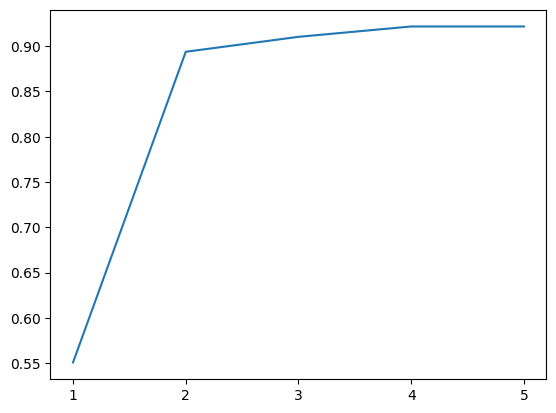

In [ ]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for depth in tqdm(range(1,6)):
      acc_fold = []

      for train_index, test_index in kf.split(data):
        train_fold, test_fold  = data.iloc[train_index], data.iloc[test_index]
        #test_fold = data.iloc[test_index]

        decision_tree3 = DecisionTree(max_depth=depth)
        decision_tree3.fit(train_fold)

        test_label = test_fold.iloc[:, -1]
        pre_label = decision_tree3.predict(test_fold)
        acc =  np.mean(pre_label == test_label)
        acc_fold.append(acc)

      accs.append(np.mean(acc_fold))

plt.plot(range(1,6), accs)
plt.xticks(range(1,6))
plt.show()